In [84]:
import numpy as np
import datetime as dt
import gsw
from netCDF4 import Dataset
from glob import glob
from scipy.io import loadmat
from seawater_scattering import betasw_wetlabs

## Data location

### -- Data used here can be found at --  

Discovery (DY_131), James Cook (JC_214), and Sarmiento de Gamboa (SdG_2015): 'R0b' data, https://drive.google.com/drive/folders/1eOIe4wNT181yFYjxgN1YECBCvyO4ZTFj  

Seaglider data (SG_219, SG_237, and SL305): https://drive.google.com/drive/folders/1R5qwjbcK0c0NsO43aVBJbb4GPnjlaGJC  

Biogeochemical float data (BGC_303 and BGC_304): https://drive.google.com/drive/folders/1RL20SX5zo9SFneicT957xlyqMtlcu683  

### -- The final .nc file can be found at --

https://drive.google.com/file/d/1SmBbt9G1jlz8o7iZ9sdc62tAl_4tFgqw (may need to request permission to view)


## T/S correction

This document corrects for T/S as in the analysis by Andrew Thompson, see document at: https://drive.google.com/drive/folders/1YceP5Z4kGsJrt3I79zou_Ci1Y3AIITlS

Specifically, the following changes were made (from as-is data from the primary sensor for each instrument):  
DY131: Use secondary T and S sensors  
JC214: Salinity offset of -0.000993 PSU  
SdG: Temperature offset of -0.0012 deg C  
SdG: Salinity offset of +0.0012 PSU  
SG219: Temperature offset of +0.0091 deg C  
SG219: Salinity offset of +0.0042 PSU  
SL305: Salinity offset of +0.0063 PSU 
BGC304: Temperature offset of +0.0094 deg C  
BGC304: Salinity offset of +0.0074 PSU  

## Backscatter and Chlorophyll Fluoresence measurements

Backscatter data are converted from measurements of the volume scattering function (VSF) using the conversion $$b_b = 2 \pi \chi VSF$$ where $\chi$ is 1.097 for measurements at 142 deg, 1.076 for measurements at 124 deg, and 1.142 for measurements at 150 deg (using the default BGC-Argo values as defined in Table 1 here: https://archimer.ifremer.fr/doc/00283/39459/56146.pdf)

Backscatter and chlorophyll fluorescence data are then filtered using sequential running (5-point) minimum and maximum filters to minimize the effects of spikes before gridding.

In [35]:
def grid_data(data,dep,grid_depth,interpolate=False):
    data = data.copy()
    ddep = np.mean(np.diff(grid_depth))
    gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])
    if interpolate:
        ii = np.isfinite(gridded_data)
        if np.sum(ii)<2:
            return gridded_data
        gridded_data[~ii] = np.interp(depth[~ii],depth[ii],gridded_data[ii],left=np.nan,right=np.nan)
    return gridded_data
def convert_date_gps(date,ref_date=dt.datetime(2021,5,1)):
    d = dt.datetime.strptime(date,'%b %d %Y  %H:%M:%S')
    dd = d-ref_date
    return dd.days + dd.seconds/86400
def convert_time_sg(time,start_date=dt.datetime(1970,1,1),ref_date=dt.datetime(2021,5,1)):
    if np.isnan(time):
        return np.nan
    d = start_date + dt.timedelta(seconds=time)
    dd = d-ref_date
    return dd.days + dd.seconds/86400
def convert_time_matlab(time):
    return time-738277
    # someone should check this...on Matlab datenum(2021,5,1) should be 738277 I hope!
    # need a more elegant solution here I know...
    

In [21]:
def min_max_filter(var,z,length=5):
    inds = np.isfinite(var) & np.isfinite(z)
    temp = np.array([np.min(var[inds][i:i+length]) for i in range(len(var[inds])-length)])
    var_bln = np.array([np.max(temp[i:i+length]) for i in range(len(temp)-length)])
    return var_bln,z[inds][length:-length]

In [4]:
depth = np.arange(1,1001)

In [107]:
# DY
DY_files = glob('./R0b/DY_131/Bin1mData/*.nc')
shape = (len(DY_files),len(depth))
DY_T = np.empty(shape=shape)
DY_S = np.empty(shape=shape)
DY_chl = np.empty(shape=shape)
DY_bbp = np.empty(shape=shape)
DY_oxy = np.empty(shape=shape)
DY_time = np.empty(shape=shape[0])
DY_lat = np.empty(shape=shape[0])
DY_lon = np.empty(shape=shape[0])
DY_sta = np.empty(shape=shape[0])
print('%d files:'%shape[0],end=' ')
for i,file in enumerate(DY_files):
    print(i,end=' ')
    nc = Dataset(file,'r')
    DY_time[i] = convert_date_gps(nc.gps_datetime)
    DY_lat[i] = nc.LATITUDE
    DY_lon[i] = nc.LONGITUDE
    DY_sta[i] = int(file[-9:-6])
    z = np.ma.filled(nc.variables['DEPTH'][:],fill_value=np.nan)
    p = gsw.p_from_z(-z,nc.LATITUDE)
    T = np.ma.filled(nc.variables['TEMP2'][:],fill_value=np.nan)
    S = np.ma.filled(nc.variables['PSAL2'][:],fill_value=np.nan)
    S[S<0] = np.nan
    bbsw = betasw_wetlabs(700,20,142,42,T,S,p)[0].squeeze()

    SA = gsw.SA_from_SP(S,p,nc.LONGITUDE,nc.LATITUDE)
    CT = gsw.CT_from_t(SA,T,p)
    oxy = np.ma.filled(nc.variables['oxygen_ml_L'][:]*44.6596*1000/(1000+nc.variables['sigma-�00'][:]),fill_value=np.nan)
    chl,chlz = min_max_filter(nc.variables['flECO-AFL'][:],z)
    bbp,bbpz = min_max_filter((nc.variables['turbWETbb0'][:]-bbsw)*2*np.pi*1.097,z)
    
    DY_T[i] = grid_data(CT,nc.variables['DEPTH'][:],depth)
    DY_S[i] = grid_data(SA,nc.variables['DEPTH'][:],depth)
    DY_chl[i] = grid_data(chl,chlz,depth)
    DY_bbp[i] = grid_data(bbp,bbpz,depth)
    DY_oxy[i] = grid_data(oxy,nc.variables['DEPTH'][:],depth)
    
    nc.close()

112 files: 0 

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 

In [108]:
# JC
JC_files = glob('./R0b/JC_214/Bin1mData/*.nc')
shape = (len(JC_files),len(depth))
JC_T = np.empty(shape=shape)
JC_S = np.empty(shape=shape)
JC_chl = np.empty(shape=shape)
JC_bbp = np.empty(shape=shape)
JC_oxy = np.empty(shape=shape)
JC_time = np.empty(shape=shape[0])
JC_lat = np.empty(shape=shape[0])
JC_lon = np.empty(shape=shape[0])
JC_sta = np.empty(shape=shape[0])

print('%d files:'%shape[0],end=' ')
for i,file in enumerate(JC_files):
    print(i,end=' ')
    nc = Dataset(file,'r')
    JC_time[i] = convert_date_gps(nc.gps_datetime)
    JC_lat[i] = nc.LATITUDE
    JC_lon[i] = nc.LONGITUDE
    JC_sta[i] = int(file[-9:-6])
    z = np.ma.filled(nc.variables['DEPTH'][:],fill_value=np.nan)
    p = gsw.p_from_z(-z,nc.LATITUDE)
    T = np.ma.filled(nc.variables['TEMP'][:],fill_value=np.nan)
    S = np.ma.filled(nc.variables['PSAL'][:],fill_value=np.nan)-0.000993
    S[S<0] = np.nan
    bbsw = betasw_wetlabs(700,20,142,42,T,S,p)[0].squeeze()

    SA = gsw.SA_from_SP(S,p,nc.LONGITUDE,nc.LATITUDE)
    CT = gsw.CT_from_t(SA,T,p)
    oxy = np.ma.filled(nc.variables['oxygen_ml_L'][:]*44.6596*1000/(1000+nc.variables['sigma-�00'][:]),fill_value=np.nan)
    chl,chlz = min_max_filter(nc.variables['flECO-AFL'][:],nc.variables['DEPTH'][:])
    bbp,bbpz = min_max_filter((nc.variables['turbWETntu0'][:]-bbsw)*2*np.pi*1.097,z)

    JC_T[i] = grid_data(CT,nc.variables['DEPTH'][:],depth)
    JC_S[i] = grid_data(SA,nc.variables['DEPTH'][:],depth)
    JC_chl[i] = grid_data(chl,chlz,depth)
    JC_bbp[i] = grid_data(bbp,bbpz,depth)
    JC_oxy[i] = grid_data(oxy,nc.variables['DEPTH'][:],depth)

    nc.close()

69 files: 0 

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/470670951.py:3: UserWarning: Warning: converting a masked element to nan.
  temp = np.array([np.min(var[inds][i:i+length]) for i in range(len(var[inds])-length)])
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 

In [109]:
# SdG
SdG_files = glob('./R0b/SdG_2015/Bin1mData/*.nc')
shape = (len(SdG_files),len(depth))
SdG_T = np.empty(shape=shape)
SdG_S = np.empty(shape=shape)
SdG_chl = np.empty(shape=shape)
SdG_bbp = np.empty(shape=shape)
SdG_oxy = np.empty(shape=shape)
SdG_time = np.empty(shape=shape[0])
SdG_lat = np.empty(shape=shape[0])
SdG_lon = np.empty(shape=shape[0])
SdG_sta = np.empty(shape=shape[0])

print('%d files:'%shape[0],end=' ')
for i,file in enumerate(SdG_files):
    print(i,end=' ')
    nc = Dataset(file,'r')
    SdG_time[i] = convert_date_gps(nc.gps_datetime)
    SdG_lat[i] = nc.LATITUDE
    SdG_lon[i] = nc.LONGITUDE
    SdG_sta[i] = int(file[-9:-6])
    
    z = np.ma.filled(nc.variables['DEPTH'][:],fill_value=np.nan)
    p = gsw.p_from_z(-z,nc.LATITUDE)
    T = np.ma.filled(nc.variables['TEMP'][:],fill_value=np.nan)-0.0012
    S = np.ma.filled(nc.variables['PSAL'][:],fill_value=np.nan)+0.0012
    S[S<0] = np.nan
    bbsw = betasw_wetlabs(700,20,142,42,T,S,p)[0].squeeze()

    SA = gsw.SA_from_SP(S,p,nc.LONGITUDE,nc.LATITUDE)
    CT = gsw.CT_from_t(SA,T,p)

    oxy = np.ma.filled(nc.variables['oxygen_ml_L'][:]*44.6596*1000/(1000+nc.variables['sigma-�00'][:]),fill_value=np.nan)
    chl,chlz = min_max_filter(nc.variables['flECO-AFL'][:],nc.variables['DEPTH'][:])
    bbp,bbpz = min_max_filter((nc.variables['turbWETntu0'][:]-bbsw)*2*np.pi*1.097,z)

    SdG_T[i] = grid_data(CT,nc.variables['DEPTH'][:],depth)
    SdG_S[i] = grid_data(SA,nc.variables['DEPTH'][:],depth)
    SdG_chl[i] = grid_data(chl,chlz,depth)
    SdG_bbp[i] = grid_data(bbp,bbpz,depth)
    SdG_oxy[i] = grid_data(oxy,nc.variables['DEPTH'][:],depth)

    nc.close()

13 files: 0 

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


1 2 3 4 5 6 7 8 9 10 11 12 

In [152]:
# SG219
nc = Dataset('Gliders/sg219_EXPORTS_Apr21_level3.nc','r')
#SG219_T = nc.variables['CT'][:,1::]
#SG219_S = nc.variables['SA'][:,1::]
SG219_S = gsw.SA_from_SP(nc.variables['S'][:,1::]+0.0042,nc.variables['P'][:,1::],nc.variables['lon'][:,1::],nc.variables['lat'][:,1::])
SG219_T = gsw.CT_from_t(SG219_S,nc.variables['T'][:,1::]+0.0091,nc.variables['P'][:,1::])
SG219_oxy = nc.variables['dissolved_oxygen'][:,1::]
SG219_lat = np.nanmean(nc.variables['lat'][:],axis=1)
SG219_lon = np.nanmean(nc.variables['lon'][:],axis=1)
SG219_sta = nc.variables['dive'][:]
SG219_time = np.array([convert_time_sg(np.nanmean(time)) for time in nc.variables['time'][:]])
SG219_chl = np.empty(shape=SG219_T.shape)
SG219_bbp = np.empty(shape=SG219_T.shape)
for i in range(len(SG219_time)):
    if np.mod(i,10)==0:
        print(i,end=' ')
    chl,z = min_max_filter(nc.variables['wlbb2fl_sig695nm_adjusted_L2'][i],
                           nc.variables['z'][:])
    SG219_chl[i] = grid_data(chl,z,depth,interpolate=True)
    T = nc.variables['T'][i]+0.0091
    S = nc.variables['S'][i]+0.0042
    p = nc.variables['P'][i]
    bbsw = betasw_wetlabs(700,20,124,41,T,S,p)
    bbp,z = min_max_filter((nc.variables['wlbb2fl_sig700nm_adjusted_L2'][i]-bbsw)*2*np.pi*1.076,
                           nc.variables['z'][:])
    SG219_bbp[i] = grid_data(bbp,z,depth,interpolate=True)
#SG219_chl = nc.variables['wlbb2fl_sig695nm_adjusted'][:,1::]

nc.close()

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/842097141.py:8: RuntimeWarning: Mean of empty slice
  SG219_lat = np.nanmean(nc.variables['lat'][:],axis=1)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/842097141.py:9: RuntimeWarning: Mean of empty slice
  SG219_lon = np.nanmean(nc.variables['lon'][:],axis=1)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/842097141.py:11: RuntimeWarning: Mean of empty slice
  SG219_time = np.array([convert_time_sg(np.nanmean(time)) for time in nc.variables['time'][:]])
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 

In [146]:
# SG237
nc = Dataset('Gliders/sg237_EXPORTS_Apr21_level3.nc','r')
SG237_T = nc.variables['CT'][:,1::]
SG237_S = nc.variables['SA'][:,1::]
SG237_oxy = nc.variables['dissolved_oxygen'][:,1::]
SG237_lat = np.nanmean(nc.variables['lat'][:],axis=1)
SG237_lon = np.nanmean(nc.variables['lon'][:],axis=1)
SG237_sta = nc.variables['dive'][:]
SG237_time = np.array([convert_time_sg(np.nanmean(time)) for time in nc.variables['time'][:]])
SG237_chl = np.empty(shape=SG237_T.shape)
SG237_bbp = np.empty(shape=SG237_T.shape)
for i in range(len(SG237_time)):
    if np.mod(i,10)==0:
        print(i,end=' ')
    chl,z = min_max_filter(nc.variables['wlbb2fl_sig695nm_adjusted_L2'][i],
                           nc.variables['z'][:])
    SG237_chl[i] = grid_data(chl,z,depth,interpolate=True)
    T = nc.variables['T'][i]
    S = nc.variables['S'][i]
    p = nc.variables['P'][i]
    bbsw = betasw_wetlabs(700,20,124,41,T,S,p)
    bbp,z = min_max_filter((nc.variables['wlbb2fl_sig700nm_adjusted_L2'][i]-bbsw)*2*np.pi*1.076,
                           nc.variables['z'][:])
    SG237_bbp[i] = grid_data(bbp,z,depth,interpolate=True)
#SG237_chl = nc.variables['wlbb2fl_sig695nm_adjusted'][:,1::]
nc.close()

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/3840752360.py:6: RuntimeWarning: Mean of empty slice
  SG237_lat = np.nanmean(nc.variables['lat'][:],axis=1)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/3840752360.py:7: RuntimeWarning: Mean of empty slice
  SG237_lon = np.nanmean(nc.variables['lon'][:],axis=1)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/3840752360.py:9: RuntimeWarning: Mean of empty slice
  SG237_time = np.array([convert_time_sg(np.nanmean(time)) for time in nc.variables['time'][:]])
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 

In [149]:
# SL305
data = loadmat('Gliders/SL305bin.mat')['SL']
#SL305_T = data['CT'][0,0][1:].T
#SL305_S = data['SA'][0,0][1:].T
p = gsw.p_from_z(data['z'][0,0][1:]*-1,data['lat'][0,0][0])
SL305_S = gsw.SA_from_SP(data['s'][0,0][1:] + 0.0063,p,data['lon'][0,0][0],data['lat'][0,0][0]).T
SL305_T = gsw.CT_from_t(SL305_S.T,data['t'][0,0][1:],p).T
SL305_oxy = data['o2'][0,0][1:].T
SL305_lon = data['lon'][0,0][0]
SL305_lat = data['lat'][0,0][0]
SL305_sta = np.arange(len(data['lon'][0,0].ravel()))+1
SL305_time = convert_time_matlab(data['mtime'][0,0][0])
SL305_chl = np.empty(shape=SL305_T.shape)
SL305_bbp = np.empty(shape=SL305_T.shape)
for i in range(len(SL305_time)):
    if np.mod(i,10)==0:
        print(i,end=' ')
    chl,z = min_max_filter(data['chl'][0,0][:,i],np.arange(1001))
    SL305_chl[i] = grid_data(chl,z,depth,interpolate=True)
    T = data['t'][0,0][:,i]
    S = data['s'][0,0][:,i]+0.0063
    P = gsw.p_from_z(data['z'][0,0][:]*-1,data['lat'][0,0][0][i])
    bbsw = betasw_wetlabs(700,20,124,41,T,S,P)
    bbp,z = min_max_filter((data['scatter700'][0,0][:,i]-bbsw)*2*np.pi*1.076,np.arange(1001))
    SL305_bbp[i] = grid_data(bbp,z,depth,interpolate=True)
#SL305_chl = data['chl'][0,0][1:].T

0 

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 

In [131]:
# BGC 303
BGC303_files = glob('./BGC_data_UWversion/1902303.*.nc')

shape = (len(BGC303_files),len(depth))
BGC303_T = np.empty(shape=shape)
BGC303_S = np.empty(shape=shape)
BGC303_chl = np.empty(shape=shape)
BGC303_bbp = np.empty(shape=shape)
BGC303_oxy = np.empty(shape=shape)
BGC303_time = np.empty(shape=shape[0])
BGC303_lat = np.empty(shape=shape[0])
BGC303_lon = np.empty(shape=shape[0])
BGC303_sta = np.empty(shape=shape[0])
print('%d files:'%shape[0],end=' ')
for i,file in enumerate(BGC303_files):
    print(i,end=' ')
    nc = Dataset(file,'r')
    BGC303_time[i] = convert_time_matlab(nc.variables['TimeStartDescent'][:].item())
    BGC303_lat[i] = nc.variables['LATITUDE'][0]
    BGC303_lon[i] = nc.variables['LONGITUDE'][0]
    BGC303_sta[i] = int(file[-6:-3])
    BGC303_T[i] = grid_data(nc.variables['TEMP_CONSERVATIVE'][:],-nc.variables['DEPTH'][:],depth,interpolate=True)
    BGC303_S[i] = grid_data(nc.variables['SAL_ABSOLUTE'][:],-nc.variables['DEPTH'][:],depth,interpolate=True)
    chl,z = min_max_filter(np.ma.filled(nc.variables['FLUORESCENCE_CHLA'][:],fill_value=np.nan),
                           -nc.variables['DEPTH'][:])
    BGC303_chl[i] = grid_data(chl,z,depth,interpolate=True)
    bbp,z = min_max_filter(np.ma.filled(nc.variables['BBP700'][:],fill_value=np.nan),
                           -nc.variables['DEPTH'][:])
    BGC303_bbp[i] = grid_data(bbp,z,depth,interpolate=True)
                           
    #BGC303_chl[i] = grid_data(np.ma.filled(nc.variables['FLUORESCENCE_CHLA'][:],fill_value=np.nan),-nc.variables['DEPTH'][:],depth,interpolate=True)
    
    BGC303_oxy[i] = grid_data(np.ma.filled(nc.variables['DOXY'][:],fill_value=np.nan),-nc.variables['DEPTH'][:],depth,interpolate=True)

    nc.close()


27 files: 0 

/Users/erickson/.conda/envs/zke/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:217: UserWarning: Warning: converting a masked element to nan.
  return a.dtype.type(a / b)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [132]:
# BGC 304
BGC304_files = glob('./BGC_data_UWversion/1902304.*.nc')

shape = (len(BGC304_files),len(depth))
BGC304_T = np.empty(shape=shape)
BGC304_S = np.empty(shape=shape)
BGC304_chl = np.empty(shape=shape)
BGC304_bbp = np.empty(shape=shape)
BGC304_oxy = np.empty(shape=shape)
BGC304_time = np.empty(shape=shape[0])
BGC304_lat = np.empty(shape=shape[0])
BGC304_lon = np.empty(shape=shape[0])
BGC304_sta = np.empty(shape=shape[0])

print('%d files:'%shape[0],end=' ')
for i,file in enumerate(BGC304_files):
    print(i,end=' ')
    nc = Dataset(file,'r')
    BGC304_time[i] = convert_time_matlab(nc.variables['TimeStartDescent'][:].item())
    BGC304_lat[i] = nc.variables['LATITUDE'][0]
    BGC304_lon[i] = nc.variables['LONGITUDE'][0]
    BGC304_sta[i] = int(file[-6:-3])
    #BGC304_T[i] = grid_data(nc.variables['TEMP_CONSERVATIVE'][:],-nc.variables['DEPTH'][:],depth,interpolate=True)
    #BGC304_S[i] = grid_data(nc.variables['SAL_ABSOLUTE'][:],-nc.variables['DEPTH'][:],depth,interpolate=True)
    SA = gsw.SA_from_SP(nc.variables['PSAL'][:]+0.0074,nc.variables['PRES'][:],nc.variables['LONGITUDE'][:],nc.variables['LATITUDE'][:])
    CT = gsw.CT_from_t(SA,nc.variables['TEMP'][:]+0.0094,nc.variables['PRES'][:])
    BGC304_T[i] = grid_data(np.ma.filled(CT,fill_value=np.nan),-1*nc.variables['DEPTH'][:],depth,interpolate=True)
    BGC304_S[i] = grid_data(np.ma.filled(SA,fill_value=np.nan),-1*nc.variables['DEPTH'][:],depth,interpolate=True)
    chl,z = min_max_filter(np.ma.filled(nc.variables['FLUORESCENCE_CHLA'][:],fill_value=np.nan),
                           -nc.variables['DEPTH'][:])
    BGC304_chl[i] = grid_data(chl,z,depth,interpolate=True)
    bbp,z = min_max_filter(np.ma.filled(nc.variables['BBP700'][:],fill_value=np.nan),
                           -nc.variables['DEPTH'][:])
    BGC304_bbp[i] = grid_data(bbp,z,depth,interpolate=True)
    #BGC304_chl[i] = grid_data(np.ma.filled(nc.variables['FLUORESCENCE_CHLA'][:],fill_value=np.nan),-nc.variables['DEPTH'][:],depth,interpolate=True)
    BGC304_oxy[i] = grid_data(np.ma.filled(nc.variables['DOXY'][:],fill_value=np.nan),-nc.variables['DEPTH'][:],depth,interpolate=True)

    nc.close()

27 files: 0 

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_48581/987151129.py:4: RuntimeWarning: Mean of empty slice
  gridded_data = np.array([np.nanmean(data[np.abs(dep-d)<ddep/2]) for d in grid_depth])


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [154]:
time = np.concatenate((DY_time,JC_time,SdG_time,SG219_time,SG237_time,SL305_time,BGC303_time,BGC304_time))
lat  = np.concatenate((DY_lat, JC_lat, SdG_lat, SG219_lat, SG237_lat, SL305_lat, BGC303_lat, BGC304_lat))
lon  = np.concatenate((DY_lon, JC_lon, SdG_lon, SG219_lon, SG237_lon, SL305_lon, BGC303_lon, BGC304_lon))
sta  = np.concatenate((DY_sta, JC_sta, SdG_sta, SG219_sta, SG237_sta, SL305_sta, BGC303_sta, BGC304_sta))

T    = np.concatenate((DY_T, JC_T, SdG_T, SG219_T, SG237_T, SL305_T, BGC303_T, BGC304_T))
S    = np.concatenate((DY_S, JC_S, SdG_S, SG219_S, SG237_S, SL305_S, BGC303_S, BGC304_S))
chl  = np.concatenate((DY_chl, JC_chl, SdG_chl, SG219_chl, SG237_chl, SL305_chl, BGC303_chl, BGC304_chl))
bbp  = np.concatenate((DY_bbp, JC_bbp, SdG_bbp, SG219_bbp, SG237_bbp, SL305_bbp, BGC303_bbp, BGC304_bbp))
oxy  = np.concatenate((DY_oxy, JC_oxy, SdG_oxy, SG219_oxy, SG237_oxy, SL305_oxy, BGC303_oxy, BGC304_oxy))



ID = np.concatenate((np.full(DY_time.shape,0),    np.full(JC_time.shape,1),
                     np.full(SdG_time.shape,2),   np.full(SG219_time.shape,3),
                     np.full(SG237_time.shape,4), np.full(SL305_time.shape,5),
                     np.full(BGC303_time.shape,6),np.full(BGC304_time.shape,7)))


In [155]:
order = np.argsort(time)
order = order[np.isfinite(time[order])]

In [157]:
NC = Dataset('EXPORTSNA_profiles.nc','w')
NC.author = 'Zachary K Erickson'
NC.contact = 'zachary.k.erickson@noaa.gov'
NC.history = 'See https://github.com/zacharykerickson/EXPORTS_analyses/blob/main/consolidate_data.ipynb'
NC.example = 'See https://github.com/zacharykerickson/EXPORTS_analyses/blob/main/look_at_data.ipynb'
NC.createDimension('profile',len(order))
NC.createDimension('depth',len(depth))

NC_ID = NC.createVariable('ID'  ,'float32',('profile',))
NC_t  = NC.createVariable('time','float32',('profile',))
NC_lat= NC.createVariable('lat', 'float32',('profile',))
NC_lon= NC.createVariable('lon', 'float32',('profile',))
NC_sta= NC.createVariable('station','uint32',('profile',))
NC_z  = NC.createVariable('depth','uint32',('depth',))
NC_T  = NC.createVariable('CT',  'float32',('profile','depth'))
NC_S  = NC.createVariable('SA',  'float32',('profile','depth'))
NC_chl= NC.createVariable('fChl','float32',('profile','depth'))
NC_bbp= NC.createVariable('bbp700','float32',('profile','depth'))
NC_oxy= NC.createVariable('oxy', 'float32',('profile','depth'))

NC_ID.longname = 'platform_ID'
NC_t.longname = 'profile_time'
NC_lat.longname = 'profile_latitude'
NC_lon.longname = 'profile_longitude'
NC_sta.longname = 'station_or_profile_number'
NC_z.longname = 'depth_below_surface'
NC_T.longname = 'conservative_temperature'
NC_S.longname = 'salinity_absolute'
NC_chl.longname = 'chlorophyll_fluorescence'
NC_bbp.longname = 'particulate_backscatter_700nm'
NC_oxy.longname = 'dissolved_oxygen'

NC_ID.units = '0: DY_131, 1: JC_214, 2: SdG_2015, 3: SG_219, 4: SG_237, 5: SL_305, 6: BGC_303, 7: BGC_304'
NC_t.units = 'days since 01 May 2021'
NC_lat.units = 'degrees North'
NC_lon.units = 'degrees East'
NC_z.units = 'm'
NC_T.units = 'deg C'
NC_S.units = 'g kg-1'
NC_chl.units = 'mg m-3'
NC_bbp.units = 'm-1'
NC_oxy.units = 'umol kg-1'

NC_ID[:] = ID[order]
NC_t[:] = time[order]
NC_lat[:] = lat[order]
NC_lon[:] = lon[order]
NC_sta[:] = sta[order]
NC_z[:] = depth
NC_T[:] = T[order]
NC_S[:] = S[order]
NC_chl[:] = chl[order]
NC_bbp[:] = bbp[order]
NC_oxy[:] = oxy[order]

NC.close()

In [56]:
nc = Dataset('EXPORTSNA_profiles.nc','r')
ID = nc.variables['ID'][:]
depth = nc.variables['depth'][:]
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
sta = nc.variables['station'][:]
time = nc.variables['time'][:]
CT = nc.variables['CT'][:]
SA = nc.variables['SA'][:]

label_string = nc.variables['ID'].units
all_IDs = np.unique(ID)
labels = [s.split(': ')[1] for s in label_string.split(', ')]

In [59]:
import matplotlib.pyplot as plt 

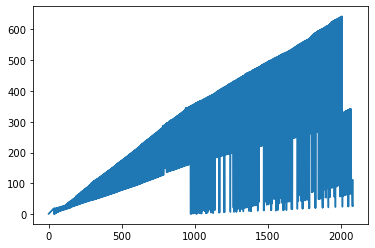

In [60]:
plt.plot(sta)

In [109]:
time_range = [5,6]
inds = (time>time_range[0]) & (time<time_range[1]) | True

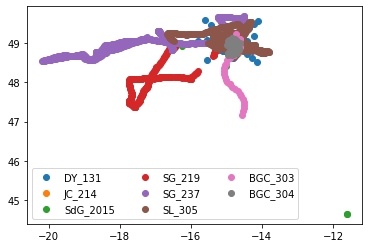

In [110]:
for i in all_IDs:
    plt.scatter(lon[inds & (ID==i)],lat[inds & (ID==i)])
plt.legend(labels,ncol=3)

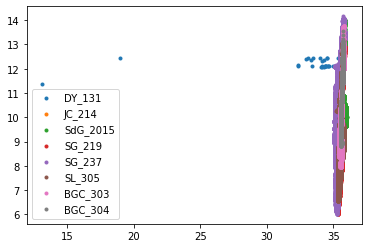

In [111]:
for i in all_IDs:
    plt.scatter(SA[inds & (ID==i)],CT[inds & (ID==i)],marker='.')
plt.legend(labels)

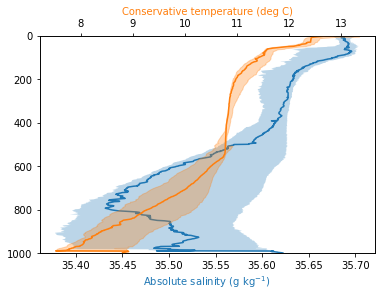

In [335]:
plt.plot(np.nanmedian(SA[inds],axis=0),depth)
plt.fill_betweenx(depth,*np.nanpercentile(SA[inds],[25,75],axis=0),alpha=0.3)
plt.xlabel('Absolute salinity (g kg$^{-1}$)',color='C0')
plt.twiny()
plt.plot(np.nanmedian(CT[inds],axis=0),depth,color='C1')
plt.fill_betweenx(depth,*np.nanpercentile(CT[inds],[25,75],axis=0),alpha=0.3,color='C1')
plt.xlabel('Conservative temperature (deg C)',color='C1')
plt.ylim([1000,0]);